In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates 

In [50]:
# Plotting style
plt.style.use('default')
sns.set_palette("husl")

ICP-SPECIFIC EDA ANALYSIS
Figures 4.9 and 4.10
Loading power demand data...
Found 48 time interval columns
Converting from kWh to kW for power demand analysis...
Data loaded: 109189 rows, 60 columns
Date range: 2022-01-01 00:00:00 to 2024-09-02 00:00:00
Unique households: 118
Data converted to kW (power demand). All analysis will focus on power demand patterns.

Finding households with complete data coverage...
Households with complete coverage: 104 out of 118

Selecting 3 representative households...
Selected households:
  1. 0000100009DE6D4: 1.4 kW
  2. 0000100075DE097: 1.8 kW
  3. 0000202787DE0F3: 2.5 kW

CREATING EDA VISUALIZATIONS

Creating Figure 4.9: Individual Household Time Series...
  Low Consumer: Min 0.0 kW, Max 4.6 kW, Avg 1.4 kW
  Medium Consumer: Min 0.1 kW, Max 5.0 kW, Avg 1.8 kW
  High Consumer: Min 0.1 kW, Max 5.8 kW, Avg 2.5 kW


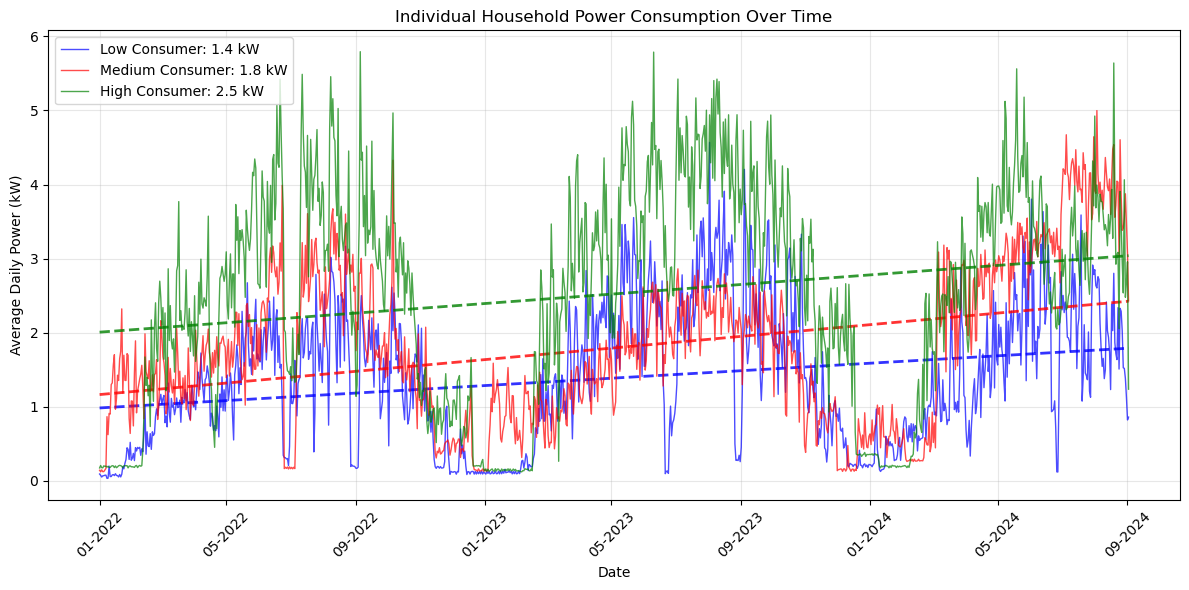


Creating Figure 4.10: Daily Load Profile Diversity...


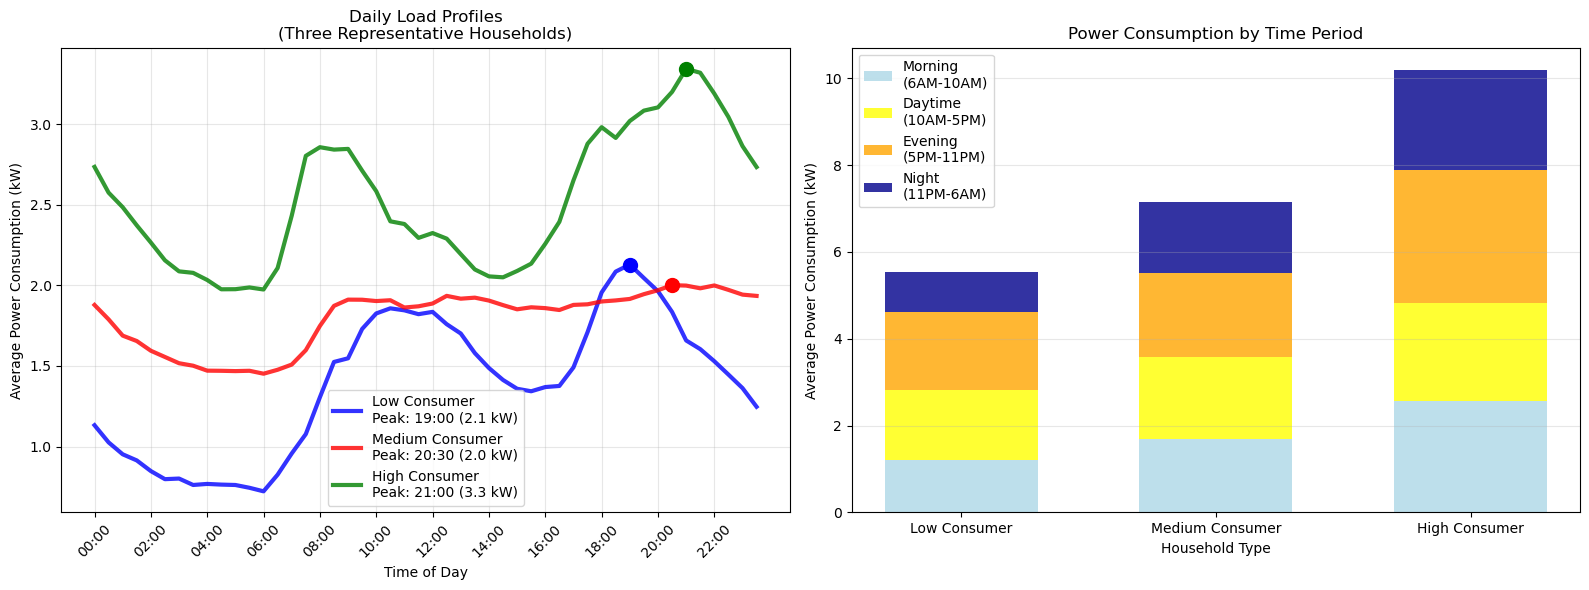

Profile Analysis:
  Low Consumer: Avg 1.4 kW, Peak 2.1 kW
  Medium Consumer: Avg 1.8 kW, Peak 2.0 kW
  High Consumer: Avg 2.5 kW, Peak 3.3 kW

ICP EDA ANALYSIS COMPLETE!


In [51]:
def load_and_prepare_data(file_path='cleaned_energy_data.csv'):
    """Load and prepare the energy dataset with CORRECT power calculations"""
    print("Loading power demand data...")
    
    # Loading the dataset
    df = pd.read_csv(file_path)
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE'])
    
    # Identify time columns 
    time_cols = [col for col in df.columns if '.' in col and '-' in col]
    print(f"Found {len(time_cols)} time interval columns")
    
    # Converting energy (kWh) to average power (kW) for 30-min intervals
    print("Converting from kWh to kW for power demand analysis...")
    df[time_cols] = df[time_cols] * 2

    # CORRECTED: Calculate average daily power (not sum!)
    df['daily_power_total'] = df[time_cols].mean(axis=1)  # Average kW across all intervals
    
    # Time-based features
    df['year'] = df['INTERVAL_DATE'].dt.year
    df['month'] = df['INTERVAL_DATE'].dt.month
    df['day_of_week'] = df['INTERVAL_DATE'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
    df['is_weekend'] = df['INTERVAL_DATE'].dt.weekday >= 5
    df['week_of_year'] = df['INTERVAL_DATE'].dt.isocalendar().week
    df['day_of_year'] = df['INTERVAL_DATE'].dt.dayofyear
    df['quarter'] = df['INTERVAL_DATE'].dt.quarter
    
    # Seasons (Southern Hemisphere)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Summer'  
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        else:
            return 'Spring'
    
    df['season'] = df['month'].apply(get_season)
    
    print(f"Data loaded: {len(df)} rows, {len(df.columns)} columns")
    print(f"Date range: {df['INTERVAL_DATE'].min()} to {df['INTERVAL_DATE'].max()}")
    print(f"Unique households: {df['ICP_IDENTIFIER'].nunique()}")
    print("Data converted to kW (power demand). All analysis will focus on power demand patterns.")
    
    return df, time_cols

def find_complete_households(df, missing_threshold=0.05):
    """Find households with nearly complete data coverage"""
    print("\nFinding households with complete data coverage...")
    
    # Define the required date range
    start_date = pd.to_datetime('2022-01-01')
    end_date = pd.to_datetime('2024-09-02')
    
    # Calculate expected number of days
    expected_days = (end_date - start_date).days + 1
    min_acceptable_days = int(expected_days * (1 - missing_threshold))
    
    # Filter data to only include the required date range
    df_filtered = df[(df['INTERVAL_DATE'] >= start_date) & (df['INTERVAL_DATE'] <= end_date)].copy()
    
    # Analyze coverage for each household
    household_coverage = df_filtered.groupby('ICP_IDENTIFIER').agg({
        'INTERVAL_DATE': ['min', 'max', 'count'],
        'daily_power_total': 'mean'
    }).round(2)
    
    # Flatten column names
    household_coverage.columns = ['min_date', 'max_date', 'day_count', 'avg_daily_power']
    
    # Find households with acceptable coverage
    complete_households = household_coverage[
        household_coverage['day_count'] >= min_acceptable_days
    ]
    
    # Further filter for date range coverage
    date_tolerance_days = 30
    complete_households = complete_households[
        (complete_households['min_date'] <= start_date + pd.Timedelta(days=date_tolerance_days)) &
        (complete_households['max_date'] >= end_date - pd.Timedelta(days=date_tolerance_days))
    ]
    
    print(f"Households with complete coverage: {len(complete_households)} out of {len(household_coverage)}")
    
    return complete_households

def select_representative_households(complete_households):
    """Select 3 representative households with different consumption patterns"""
    print("\nSelecting 3 representative households...")
    
    # Sort by consumption
    complete_households_sorted = complete_households.sort_values('avg_daily_power')
    
    # Get quartiles
    q25 = complete_households_sorted['avg_daily_power'].quantile(0.25)
    q50 = complete_households_sorted['avg_daily_power'].quantile(0.50)
    q75 = complete_households_sorted['avg_daily_power'].quantile(0.75)
    
    # Select households from different consumption levels
    low_candidates = complete_households_sorted[
        complete_households_sorted['avg_daily_power'] <= q25 + 0.1
    ]
    low_consumer = low_candidates.iloc[len(low_candidates)//2].name if len(low_candidates) > 0 else complete_households_sorted.iloc[0].name
    
    medium_candidates = complete_households_sorted[
        (complete_households_sorted['avg_daily_power'] >= q50 - 0.1) &
        (complete_households_sorted['avg_daily_power'] <= q50 + 0.1)
    ]
    medium_consumer = medium_candidates.iloc[0].name if len(medium_candidates) > 0 else complete_households_sorted.iloc[len(complete_households_sorted)//2].name
    
    high_candidates = complete_households_sorted[
        complete_households_sorted['avg_daily_power'] >= q75 - 0.1
    ]
    high_consumer = high_candidates.iloc[-len(high_candidates)//2].name if len(high_candidates) > 0 else complete_households_sorted.iloc[-1].name
    
    selected_households = [low_consumer, medium_consumer, high_consumer]
    
    print(f"Selected households:")
    for i, hh in enumerate(selected_households, 1):
        consumption = complete_households.loc[hh, 'avg_daily_power']
        print(f"  {i}. {hh}: {consumption:.1f} kW")
    
    return selected_households

def plot_household_time_series(df, selected_households):
    """Figure 4.9: Individual household consumption over time"""
    print("\nCreating Figure 4.9: Individual Household Time Series...")
    
    # Filter to selected households
    df_selected = df[df['ICP_IDENTIFIER'].isin(selected_households)].copy()
    
    # Create single plot (not subplot)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    colors = ['blue', 'red', 'green']
    labels = ['Low Consumer', 'Medium Consumer', 'High Consumer']
    
    for i, (household, color, label) in enumerate(zip(selected_households, colors, labels)):
        household_df = df_selected[df_selected['ICP_IDENTIFIER'] == household].copy()
        household_df = household_df.sort_values('INTERVAL_DATE')
        avg_consumption = household_df['daily_power_total'].mean()
        print(f"  {label}: Min {household_df['daily_power_total'].min():.1f} kW, Max {household_df['daily_power_total'].max():.1f} kW, Avg {avg_consumption:.1f} kW")
        
        # Plot time series
        ax.plot(household_df['INTERVAL_DATE'], household_df['daily_power_total'], 
                color=color, alpha=0.7, linewidth=1, 
                label=f'{label}: {avg_consumption:.1f} kW')
        
        # Add trend line
        days_numeric = (household_df['INTERVAL_DATE'] - household_df['INTERVAL_DATE'].min()).dt.days
        z = np.polyfit(days_numeric, household_df['daily_power_total'], 1)
        p = np.poly1d(z)
        ax.plot(household_df['INTERVAL_DATE'], p(days_numeric), '--', color=color, alpha=0.8, linewidth=2)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Daily Power (kW)')
    ax.set_title('Individual Household Power Consumption Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_household_daily_profiles(df, selected_households, time_cols):
    """Figure 4.10: Daily load profile diversity"""
    print("\nCreating Figure 4.10: Daily Load Profile Diversity...")
    
    # Filter to selected households
    df_selected = df[df['ICP_IDENTIFIER'].isin(selected_households)].copy()
    
    # Create time labels
    time_labels = [f'{i//2:02d}:{(i%2)*30:02d}' for i in range(48)]
    
    # Calculate profiles
    household_profiles = {}
    household_stats = {}
    
    for household in selected_households:
        household_df = df_selected[df_selected['ICP_IDENTIFIER'] == household]
        avg_profile = household_df[time_cols].mean()
        household_profiles[household] = avg_profile
        
        household_stats[household] = {
            'avg_daily': household_df['daily_power_total'].mean(),
            'peak_time_idx': avg_profile.idxmax(),
            'peak_value': avg_profile.max(),
            'min_value': avg_profile.min()
        }
    
    # Create subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Overlaid daily profiles
    colors = ['blue', 'red', 'green']
    labels = ['Low Consumer', 'Medium Consumer', 'High Consumer']
    
    for i, (household, color, label) in enumerate(zip(selected_households, colors, labels)):
        profile = household_profiles[household]
        stats = household_stats[household]
        
        # Get peak time for display
        peak_time_col = stats['peak_time_idx']
        peak_time_parts = peak_time_col.split('.')
        peak_hour = int(peak_time_parts[0])
        peak_minute = 30 if len(peak_time_parts) > 1 and '30' in peak_time_parts[1] else 0
        peak_idx = peak_hour * 2 + (1 if peak_minute == 30 else 0)
        
        # Plot profile
        ax1.plot(range(48), profile.values, color=color, linewidth=3, alpha=0.8,
                label=f'{label}\nPeak: {peak_hour:02d}:{peak_minute:02d} ({stats["peak_value"]:.1f} kW)')
        
        # Mark peak
        ax1.scatter([peak_idx], [stats['peak_value']], color=color, s=100, zorder=5)
    
    # Format left plot
    ax1.set_xticks(range(0, 48, 4))
    ax1.set_xticklabels([time_labels[i] for i in range(0, 48, 4)], rotation=45)
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Average Power Consumption (kW)')
    ax1.set_title('Daily Load Profiles\n(Three Representative Households)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Time period comparison
    characteristics = []
    household_names = []
    
    for i, (household, label) in enumerate(zip(selected_households, labels)):
        profile = household_profiles[household]
        
        # Calculate time period averages
        morning_avg = profile.iloc[12:20].mean()  # 6AM-10AM
        day_avg = profile.iloc[20:34].mean()      # 10AM-5PM  
        evening_avg = profile.iloc[34:46].mean()  # 5PM-11PM
        night_avg = profile.iloc[list(range(0, 12)) + list(range(46, 48))].mean()  # 11PM-6AM
        
        characteristics.append([morning_avg, day_avg, evening_avg, night_avg])
        household_names.append(f'{label}')
    
    # Create stacked bar chart
    characteristics = np.array(characteristics)
    periods = ['Morning\n(6AM-10AM)', 'Daytime\n(10AM-5PM)', 'Evening\n(5PM-11PM)', 'Night\n(11PM-6AM)']
    period_colors = ['lightblue', 'yellow', 'orange', 'darkblue']
    
    x = np.arange(len(household_names))
    width = 0.6
    
    bottom = np.zeros(len(household_names))
    for i, (period, color) in enumerate(zip(periods, period_colors)):
        ax2.bar(x, characteristics[:, i], width, bottom=bottom, 
                label=period, color=color, alpha=0.8)
        bottom += characteristics[:, i]
    
    ax2.set_xlabel('Household Type')
    ax2.set_ylabel('Average Power Consumption (kW)')
    ax2.set_title('Power Consumption by Time Period')
    ax2.set_xticks(x)
    ax2.set_xticklabels(household_names)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print(f"Profile Analysis:")
    for i, (household, label) in enumerate(zip(selected_households, labels)):
        stats = household_stats[household]
        print(f"  {label}: Avg {stats['avg_daily']:.1f} kW, Peak {stats['peak_value']:.1f} kW")

def run_icp_eda_analysis():
    """Run ICP-specific EDA analysis for thesis figures 4.9 and 4.10"""
    print("=" * 50)
    print("ICP-SPECIFIC EDA ANALYSIS")
    print("Figures 4.9 and 4.10")
    print("=" * 50)
    
    # Load data
    df, time_cols = load_and_prepare_data()
    
    # Find complete households
    complete_households = find_complete_households(df)
    
    if len(complete_households) < 3:
        print(f"Error: Only {len(complete_households)} households found!")
        return
    
    # Select representative households
    selected_households = select_representative_households(complete_households)
    
    # Create the plots
    print("\n" + "="*40)
    print("CREATING EDA VISUALIZATIONS")
    print("="*40)
    
    # Figure 4.9: Household consumption patterns
    plot_household_time_series(df, selected_households)
    
    # Figure 4.10: Daily profile diversity
    plot_household_daily_profiles(df, selected_households, time_cols)
    
    print("\n" + "="*40)
    print("ICP EDA ANALYSIS COMPLETE!")
    print("="*40)

# Run the analysis
if __name__ == "__main__":
    run_icp_eda_analysis()